In [1]:
#Covariance 3x2 + cluster version 1 - Dec 1st 2019
# NxN, NxCls (gg, gk, kk) 
# Incorporates Photo-z uncertainties and mass-richness relationship
# mass integral taken outside (assuming average redshift within bin)
# units now checked 
# Limber approximation added to check Ncl and Ncl
# Limber assuming for C-ells (l)
# using 2FAST algorithm to tackle double bessel integrals 
# using approximation formula from Assassi, Simonovic and Zaldarriaga paper to overcome Hypergeometric function of a complex argument
# assuming full sky for now
# Included shot noise (1-halo term)
# Added full matrix in the end 

# *****************************************************************

#import necessary modules for our computation
import numpy as np
import time
from scipy.integrate import romb, quad  #this will be necessary for some integrals
from scipy.special import gamma #this will import spherical bessel functions, gamma and Gauss Hypergeometric function
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pyccl as ccl #import CCL python wrapper  

In [2]:
#Setup initial cosmology and Make a ccl class. We will later vary them for MCMC
Omg_c = 0.26
Omg_b = 0.04
h0 = 0.67 #so H0 = 100h0 will be in km/s/Mpc
A_s_value = 2.1e-9
n_s_value = 0.96
w_0 = -1.
w_a = 0.0
overdensity_delta = 200
c = 299792.458 # in km/s

survey_area = 4*np.pi #assuming full sky for now

cosmo = ccl.Cosmology(Omega_c = Omg_c, 
                      Omega_b = Omg_b, 
                      h = h0, 
                      A_s = A_s_value, 
                      n_s = n_s_value, 
                      w0 = w_0, wa = w_a)

In [3]:
#Define arrays for bins for Photometric z and Z grid
Zmin = 0.3
Zmax = 1.2
Z_bin_range = 0.05
Num_z_bins = round((Zmax-Zmin)/Z_bin_range)
Z_bins = np.round(np.linspace(Zmin,Zmax,Num_z_bins+1),2)
print(Z_bins, Num_z_bins)
print("Minimum radial distance is " + str(ccl.comoving_radial_distance(cosmo, 1/(1+Z_bins[0])))+ " Mpc")
print("Maximum radial distance is " + str(ccl.comoving_radial_distance(cosmo, 1/(1+Z_bins[Num_z_bins])))+ " Mpc")

[0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95
 1.   1.05 1.1  1.15 1.2 ] 18
Minimum radial distance is 1247.8400578373084 Mpc
Maximum radial distance is 3931.479845283442 Mpc


In [4]:
# insert function that calculates Photo z, given true redshift z_true and photometric bin z_i
def photoz(z_true, z_i): 
    sigma_z = 0.05*(1+z_true)
    integrand = lambda z_phot: np.exp(- (z_phot - z_true)**2. / (2.*sigma_z**2.))/ (np.sqrt(2.*np.pi) * sigma_z)
    return (quad(integrand,Z_bins[z_i], Z_bins[z_i+1])[0]/(1.-quad(integrand, -np.inf, 0.)[0]))
# Notice that I am truncating the pdf, so as to absorb the negative redshifts into the positive part of the pdf

Lim_z_min = max(0.02, Z_bins[0]-4*Z_bin_range) #minimum z_true for the integrals. I am assuming z_true>0.02 
Lim_z_max = Z_bins[-1]+6*Z_bin_range #maximum z_true for the integrals, assuming 40% larger than max z, so we dont need to go till infinity

Lim_R_min = ccl.comoving_radial_distance(cosmo, 1/(1+Lim_z_min))
Lim_R_max = ccl.comoving_radial_distance(cosmo, 1/(1+Lim_z_max))

print(Lim_z_min, Lim_R_min)
print(Lim_z_max, Lim_R_max)

0.09999999999999998 437.18704239759813
1.5 4558.602004298992


In [5]:
#define function for dv1 = comoving volume per steridian as function of z_true for a photometric redshift bin; dv(z) = dz*dr/dz(z)*(r(z)**2)*photoz(z, bin z_i)
          
def dV(z_true, z_i): #output will be in Mpc**3
    return c*(ccl.comoving_radial_distance(cosmo, 1/(1+z_true))**2)/(100*h0*ccl.h_over_h0(cosmo,1/(1+z_true)))*(photoz(z_true, z_i))
   

In [6]:
# define logarithmically-spaced richness bins 
Lbdmin = 10
Lbdmax = 100
Lbd_bin_range = 30
Num_Lbd_bins = round((Lbdmax-Lbdmin)/Lbd_bin_range)
Lbd_bins = np.round(np.logspace(np.log10(Lbdmin),np.log10(Lbdmax),Num_Lbd_bins+1),2)
print(Lbd_bins, Num_Lbd_bins)

[ 10.    21.54  46.42 100.  ] 3


In [7]:
# Define lognormal mass-richness relation (leveraging paper from Murata et. alli - ArxIv 1707.01907 and Costanzi et all ArxIv 1810.09456v1)
A = 3.207 #Murata
B = 0.75 #Costanzi
sigma_zero = 2.68 # Costanzi
q = 0.54 # # Costanzi
M_pivot = 3.e+14/h0 #in solar masses , Murata and Costanzi use it 

#Function that returns the probability that the true mass ln(M_true) is observed within the bins lambda_i and lambda_i + 1 
def mass_richness (Ln_M_true, lbd_i): 
    sigma_lambda = sigma_zero+q*(Ln_M_true-np.log(M_pivot))
    average = A+B*(Ln_M_true-np.log(M_pivot))
    integrand = lambda lbd: (1./lbd)*np.exp(- (np.log(lbd)-average)**2. / (2.*sigma_lambda**2.))/ (np.sqrt(2.*np.pi) * sigma_lambda)
    return (quad(integrand,Lbd_bins[lbd_i], Lbd_bins[lbd_i+1])[0])

Mmin = np.log(1.e+13) #minimum log mass in solar masses; below this the probability is almost nill
Mmax = np.log(1.e+16) #maximum log mass in solar masses; above this the halo mass function is below 10^⁻10

# just testing which percentage is obtained for the minimum and maximum masses within the richness limits
test_min = [mass_richness(Mmin, i) for i in range(Num_Lbd_bins)]
print(np.sum(test_min))
print(ccl.massfunc(cosmo, np.exp(Mmax), 1/(1+Lim_z_min), overdensity=overdensity_delta))

0.0009528852621284171
1.3009749580368971e-11


In [8]:
# define integral that calculates the response of nh to variations in background density 
def integral_mass (z, lbd_i): #z is the redshift; i is the lambda bin,with lambda from Lambda_bins[i] to Lambda_bins[i+1]
    f = lambda ln_m:(1/np.log(10))*ccl.massfunc(cosmo, np.exp(ln_m),1/(1+z),overdensity = overdensity_delta)*ccl.halo_bias(cosmo, np.exp(ln_m),1/(1+z),overdensity = overdensity_delta)*mass_richness(ln_m, lbd_i)
    #Remember ccl.function returns dn/dlog10m, I am changing integrand to d(lnM)
    return quad(f, Mmin, Mmax)[0]


  

In [9]:
#Calculate 2D array for mass integrals
mass_array = np.zeros((Num_z_bins, Num_Lbd_bins))
for z_i in range(Num_z_bins):
    for lbd_i in range(Num_Lbd_bins):
        mass_array[z_i,lbd_i] = integral_mass(0.5*(Z_bins[z_i]+Z_bins[z_i+1]),lbd_i)

In [10]:
print(mass_array)

[[2.56745394e-05 1.38508867e-05 7.50124757e-06]
 [2.58298018e-05 1.38199224e-05 7.41684132e-06]
 [2.59266311e-05 1.37530305e-05 7.31198047e-06]
 [2.59625979e-05 1.36499573e-05 7.18724475e-06]
 [2.59359525e-05 1.35108989e-05 7.04347148e-06]
 [2.58456491e-05 1.33364910e-05 6.88173323e-06]
 [2.56913539e-05 1.31277876e-05 6.70331076e-06]
 [2.54734386e-05 1.28862331e-05 6.50966249e-06]
 [2.51929598e-05 1.26136257e-05 6.30239155e-06]
 [2.48516256e-05 1.23120754e-05 6.08321130e-06]
 [2.44517534e-05 1.19839606e-05 5.85391233e-06]
 [2.39962157e-05 1.16318775e-05 5.61632764e-06]
 [2.34883789e-05 1.12585911e-05 5.37230098e-06]
 [2.29320385e-05 1.08669857e-05 5.12365718e-06]
 [2.23313490e-05 1.04600167e-05 4.87217544e-06]
 [2.16907529e-05 1.00406645e-05 4.61956554e-06]
 [2.10149086e-05 9.61189123e-06 4.36744734e-06]
 [2.03086188e-05 9.17660047e-06 4.11733379e-06]]


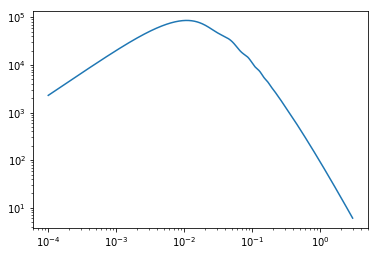

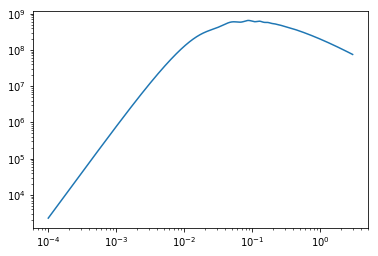

2293.8187696736672 74686413.61445285
[1.00000000e-04 1.01012812e-04 1.02035883e-04 ... 2.94014216e+00
 2.96992028e+00 3.00000000e+00]


In [12]:
# Prepare r array and k array for 2-FAST
#Define main parameters
ko = 1.e-4
kmax = 3
ro = 1/kmax
rmax = 1/ko
G = np.log(kmax/ko)
N = 1024
L = 2*np.pi*N/G
k_vec = np.logspace(np.log(ko), np.log(kmax), N, base = np.exp(1))
r_vec = np.logspace(np.log(ro), np.log(rmax), N, base = np.exp(1))
bias_fft = 1.4165
pk_vec = ccl.linear_matter_power(cosmo, k_vec, 1)
fk_vec = (k_vec/ko)**(3.-bias_fft)*pk_vec # this is the function to be fftlog-ed 
plt.loglog(k_vec, pk_vec)
plt.show()
plt.loglog(k_vec, fk_vec)
plt.show()
print(fk_vec[0], fk_vec[-1])
print(k_vec)

In [13]:
# Performing the FFT of the fk_vec function, leveraging the fact it is real
Phi_vec = np.conjugate(np.fft.rfft(fk_vec))/L

In [14]:
#Calculating the function M_0_0
def I_ell (m, R): #the formula below only valid for R <=1, l = 0,  formula B2 ASZ and 31 from 2-fast paper 
    t_m = 2*np.pi*m/G
    alpha_m = bias_fft-1.j*t_m
    pre_factor =(ko*ro)**(-alpha_m)
    if R<1:
        return pre_factor*0.5*np.cos(np.pi*alpha_m/2)*gamma(alpha_m-2)*(1/R)*((1+R)**(2-alpha_m)-(1-R)**(2-alpha_m))
    elif R==1:
        return pre_factor*0.5*np.cos(np.pi*alpha_m/2)*gamma(alpha_m-2)*((1+R)**(2-alpha_m))
    

In [15]:
#this range includes the Min and  Max limits of the integrals, with a +- safety factor of 5
Index_min = np.int(np.argwhere(r_vec>Lim_R_min)[0]-5)
Index_max = np.int(np.argwhere(r_vec<Lim_R_max)[-1]+5)
print(Index_min,Index_max)

708 950


In [16]:
# function that calculates the double bessel integral from I-ell algorithm, as function of z1 and z2
def double_bessel_integral (z1,z2):
    r2 = ccl.comoving_radial_distance(cosmo, 1/(1+z2))
    r1 = ccl.comoving_radial_distance(cosmo, 1/(1+z1))
    R = min(r1, r2)/max(r1, r2) #definition of t, forcing it to be <= 1
    I_ell_vec = [I_ell(m,R) for m in range(N//2+1)]
    back_FFT_vec = np.fft.irfft(Phi_vec*I_ell_vec)*N # FFT back
    two_fast_vec = (1/np.pi)*(ko**3)*((r_vec/ro)**(-bias_fft))*back_FFT_vec/G
    f = interp1d(r_vec[Index_min:Index_max],two_fast_vec[Index_min:Index_max], kind = 'cubic') #we will use this to interpolate the exact r(z1)
    return f(max(r1, r2))
    


In [17]:
print(double_bessel_integral(0.1,0.1))

0.0006499908996327016


In [21]:
# Now we define photo-Z adjusted dNdZ 

def dNdZ_true (z, alpha=1.24, beta=1.01, z0=0.51):
    """Smail et al. 1994 redshift dist"""
    return np.power(z, alpha) * np.exp(-np.power(z/z0, beta))
nz = 150
z_true_vec = np.linspace(Lim_z_min, Lim_z_max,nz)

#Normalized dNdZ array as a function of z_true per photo-z bin
dNdZ_photo_bin = np.zeros((Num_z_bins,nz))
for z_i in range (Num_z_bins):
    denom = lambda x: dNdZ_true(x)*photoz(x, z_i)
    dNdZ_photo_bin[z_i] = [dNdZ_true(z_true_vec[i])*photoz(z_true_vec[i],z_i)/quad(denom, Lim_z_min, Lim_z_max)[0] for i in range (nz)]

print(dNdZ_photo_bin)





[[1.01695566e-03 2.34541262e-03 5.11118733e-03 ... 4.92776411e-19
  3.33475910e-19 2.25932769e-19]
 [1.88631564e-05 5.37171202e-05 1.43578829e-04 ... 1.72633742e-17
  1.17166335e-17 7.96007505e-18]
 [1.60620062e-07 5.73091030e-07 1.90568568e-06 ... 5.26207287e-16
  3.58607300e-16 2.44596203e-16]
 ...
 [2.86030540e-66 7.02451967e-64 1.42070713e-61 ... 1.07398788e-02
  8.60942651e-03 6.88496607e-03]
 [2.84736009e-73 1.06856147e-70 3.26329494e-68 ... 3.80977698e-02
  3.11832074e-02 2.54534202e-02]
 [1.24888525e-80 7.26283531e-78 3.39511276e-75 ... 1.15624349e-01
  9.67459421e-02 8.06986151e-02]]


In [22]:
#Define standard CCL tracers for position and shear
bg = 1.3*np.ones(nz) #Assuming constant linear bias for now

Gal_position = np.array([ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_true_vec, dNdZ_photo_bin[z_i]), bias=(z_true_vec, bg)) for z_i in range (Num_z_bins)])
Gal_shear = np.array([ccl.WeakLensingTracer(cosmo, dndz=(z_true_vec, dNdZ_photo_bin[z_i])) for z_i in range(Num_z_bins)])


print(ccl.angular_cl(cosmo, Gal_position[1],Gal_position[1],100), ccl.angular_cl(cosmo, Gal_position[1], Gal_shear[1], 100), ccl.angular_cl(cosmo, Gal_shear[1], Gal_shear[1],100))
print(ccl.angular_cl(cosmo, Gal_position[1],Gal_position[1],400), ccl.angular_cl(cosmo, Gal_position[1], Gal_shear[1], 400), ccl.angular_cl(cosmo, Gal_shear[1], Gal_shear[1],400))
print(ccl.angular_cl(cosmo, Gal_position[1],Gal_position[1],1000), ccl.angular_cl(cosmo, Gal_position[1], Gal_shear[1], 1000), ccl.angular_cl(cosmo, Gal_shear[1], Gal_shear[1],1000))

1.1007867362938151e-05 2.9100140367012055e-08 1.163909498821603e-09
1.6901492025627163e-06 4.622927679896756e-09 2.3278051390017473e-10
6.245014132577745e-07 1.7495453171962112e-09 7.236937816659259e-11


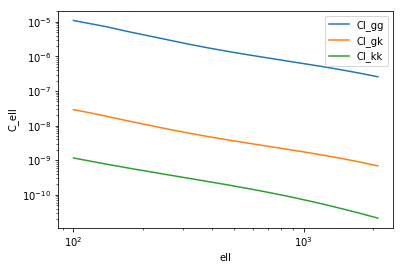

In [24]:
#Printing variation of Cls with l for a given z 
ell_print = np.linspace(100,2100,1000)
plt.loglog(ell_print, ccl.angular_cl(cosmo, Gal_position[1], Gal_position[1], ell_print), label = "Cl_gg")
plt.loglog(ell_print, ccl.angular_cl(cosmo, Gal_position[1], Gal_shear[1], ell_print), label = "Cl_gk")
plt.loglog(ell_print, ccl.angular_cl(cosmo, Gal_shear[1], Gal_shear[1], ell_print), label = "Cl_kk")
plt.xlabel("ell")
plt.ylabel("C_ell")
plt.legend()
plt.show()

6.176244186750379e-07
1.3013292639107498e-06
(150, 1024)


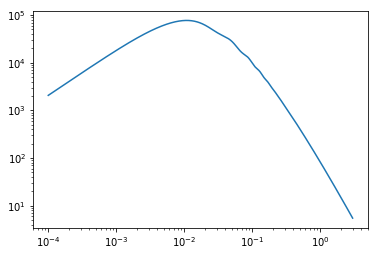

In [25]:
#Create power spectrum

scale_factor_vec = 1/(1+z_true_vec[::-1])
lpk_array = np.array([ccl.linear_matter_power(cosmo,k_vec,a) for a in scale_factor_vec])
Growth_vector = np.array([ccl.growth_factor(cosmo, a) for a in scale_factor_vec])
# TestingPk2D object for ell = 500
pk_original = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_array, is_logp=False)
print(ccl.angular_cl(cosmo, Gal_position[1], Gal_position[1], 500, p_of_k_a=pk_original))
print(ccl.angular_cl(cosmo, Gal_position[1], Gal_position[1],500))
plt.loglog(k_vec, lpk_array[-1])
print(lpk_array.shape)

In [26]:
#Create sigma square
sigma_vec = np.array([double_bessel_integral(z,z) for z in z_true_vec[::-1]])
print(sigma_vec.shape)
print(sigma_vec)


(150,)
[1.13235718e-05 1.13716298e-05 1.14204967e-05 1.14701915e-05
 1.15207360e-05 1.15721490e-05 1.16244529e-05 1.16776695e-05
 1.17318226e-05 1.17869361e-05 1.18430329e-05 1.19001392e-05
 1.19582803e-05 1.20174852e-05 1.20777797e-05 1.21391934e-05
 1.22017550e-05 1.22654972e-05 1.23304509e-05 1.23966489e-05
 1.24641246e-05 1.25329144e-05 1.26030554e-05 1.26745843e-05
 1.27475399e-05 1.28219637e-05 1.28978987e-05 1.29753874e-05
 1.30544745e-05 1.31352082e-05 1.32176378e-05 1.33018131e-05
 1.33877852e-05 1.34756116e-05 1.35653479e-05 1.36570528e-05
 1.37507863e-05 1.38466157e-05 1.39446049e-05 1.40448221e-05
 1.41473411e-05 1.42522370e-05 1.43595865e-05 1.44694697e-05
 1.45819752e-05 1.46971882e-05 1.48152002e-05 1.49361111e-05
 1.50600184e-05 1.51870267e-05 1.53172475e-05 1.54507945e-05
 1.55877868e-05 1.57283507e-05 1.58726172e-05 1.60207226e-05
 1.61728121e-05 1.63290356e-05 1.64895509e-05 1.66545259e-05
 1.68241308e-05 1.69985508e-05 1.71779797e-05 1.73626130e-05
 1.75526694e-05 1

In [27]:
#Create dV array
dV_vec = np.zeros((Num_z_bins, nz))
for z_i in range (Num_z_bins):
    dV_vec[z_i] = np.array([dV(z,z_i) for z in z_true_vec[::-1]])
print(dV_vec[0].shape)    

(150,)


In [28]:
#finally calculating the covariance under 1st order PT
n_ell = 3
ell_vec = np.linspace(200,260,n_ell)


def COV_N_Cl_gg (z_a, z_b, z_cl, lbd):
    lpk_aux = np.transpose(np.transpose(lpk_array)*dV_vec[z_cl]*sigma_vec*(Growth_vector**2)*68/21)#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    return survey_area*ccl.angular_cl(cosmo, Gal_position[z_a], Gal_position[z_b], ell_vec, p_of_k_a=pk_adjusted)*mass_array[z_cl, lbd]
def COV_N_Cl_gk (z_a, z_b, z_cl, lbd):
    lpk_aux = np.transpose(np.transpose(lpk_array)*dV_vec[z_cl]*sigma_vec*(Growth_vector**2)*68/21)#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    return survey_area*ccl.angular_cl(cosmo, Gal_position[z_a], Gal_shear[z_b], ell_vec, p_of_k_a=pk_adjusted)*mass_array[z_cl, lbd]
def COV_N_Cl_kk (z_a, z_b, z_cl, lbd):
    lpk_aux = np.transpose(np.transpose(lpk_array)*dV_vec[z_cl]*sigma_vec*(Growth_vector**2)*68/21)#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    return survey_area*ccl.angular_cl(cosmo, Gal_shear[z_a], Gal_shear[z_b], ell_vec, p_of_k_a=pk_adjusted)*mass_array[z_cl, lbd]

print(COV_N_Cl_gg(1,2,3,1))
print(COV_N_Cl_gk(4,5,5,0))
print(COV_N_Cl_kk(2,2,2,2))

[8.90171983e-05 7.04664420e-05 5.59799315e-05]
[5.26861482e-07 4.12518995e-07 3.39601483e-07]
[8.78090821e-10 6.77531084e-10 5.37696915e-10]


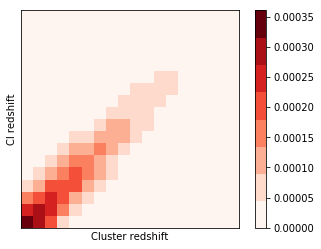

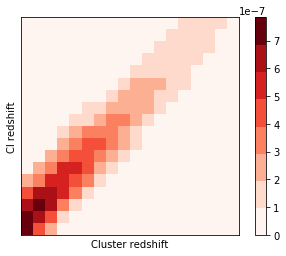

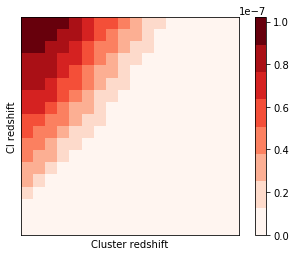

In [29]:
#Testing for low richness, low ell, assuming same photo-z for the C-ells tracers
matrix_gg = np.zeros((Num_z_bins, Num_z_bins))
matrix_gk = np.zeros((Num_z_bins, Num_z_bins))
matrix_kk = np.zeros((Num_z_bins, Num_z_bins))
for z_cl in range (Num_z_bins):
    for z_tracer in range(Num_z_bins):
        matrix_gg[z_cl,z_tracer] = COV_N_Cl_gg(z_tracer,z_tracer,z_cl,0)[0]
        matrix_gk[z_cl,z_tracer] = COV_N_Cl_gk(z_tracer,z_tracer,z_cl,0)[0]
        matrix_kk[z_cl,z_tracer] = COV_N_Cl_kk(z_tracer,z_tracer,z_cl,0)[0]
        
plt.imshow(np.rot90(matrix_gg), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        

plt.imshow(np.rot90(matrix_gk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        

plt.imshow(np.rot90(matrix_kk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        


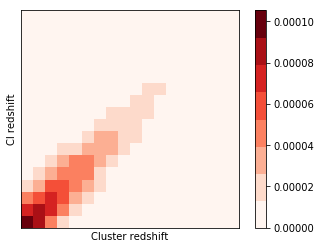

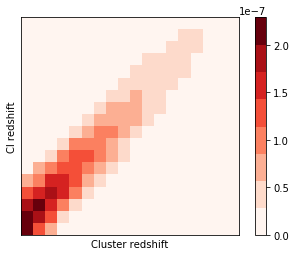

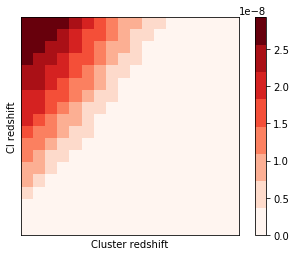

In [30]:
#Testing for high richness, low ell, assuming same photo-z for the C-ells tracers
matrix_gg = np.zeros((Num_z_bins, Num_z_bins))
matrix_gk = np.zeros((Num_z_bins, Num_z_bins))
matrix_kk = np.zeros((Num_z_bins, Num_z_bins))
for z_cl in range (Num_z_bins):
    for z_tracer in range(Num_z_bins):
        matrix_gg[z_cl,z_tracer] = COV_N_Cl_gg(z_tracer,z_tracer,z_cl,2)[0]
        matrix_gk[z_cl,z_tracer] = COV_N_Cl_gk(z_tracer,z_tracer,z_cl,2)[0]
        matrix_kk[z_cl,z_tracer] = COV_N_Cl_kk(z_tracer,z_tracer,z_cl,2)[0]
        
plt.imshow(np.rot90(matrix_gg), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        

plt.imshow(np.rot90(matrix_gk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        

plt.imshow(np.rot90(matrix_kk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        


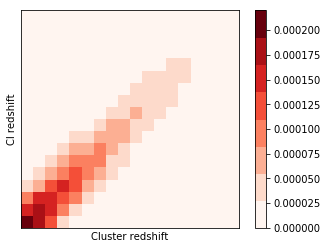

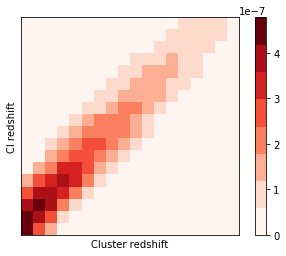

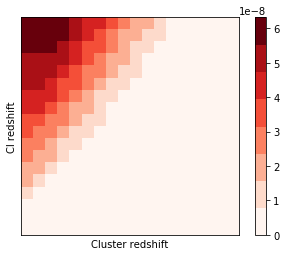

In [31]:
#Testing for low richness, high ell, assuming same photo-z for the C-ells tracers
matrix_gg = np.zeros((Num_z_bins, Num_z_bins))
matrix_gk = np.zeros((Num_z_bins, Num_z_bins))
matrix_kk = np.zeros((Num_z_bins, Num_z_bins))
for z_cl in range (Num_z_bins):
    for z_tracer in range(Num_z_bins):
        matrix_gg[z_cl,z_tracer] = COV_N_Cl_gg(z_tracer,z_tracer,z_cl,0)[-1]
        matrix_gk[z_cl,z_tracer] = COV_N_Cl_gk(z_tracer,z_tracer,z_cl,0)[-1]
        matrix_kk[z_cl,z_tracer] = COV_N_Cl_kk(z_tracer,z_tracer,z_cl,0)[-1]
        
plt.imshow(np.rot90(matrix_gg), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        

plt.imshow(np.rot90(matrix_gk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        

plt.imshow(np.rot90(matrix_kk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        


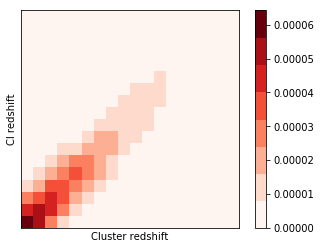

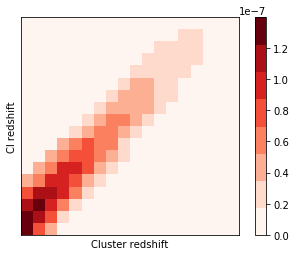

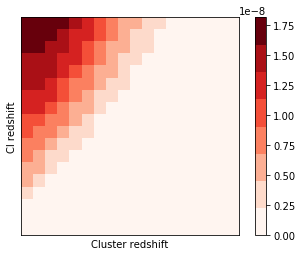

In [32]:
#Testing for high richness, high ell, assuming same photo-z for the C-ells tracers
matrix_gg = np.zeros((Num_z_bins, Num_z_bins))
matrix_gk = np.zeros((Num_z_bins, Num_z_bins))
matrix_kk = np.zeros((Num_z_bins, Num_z_bins))
for z_cl in range (Num_z_bins):
    for z_tracer in range(Num_z_bins):
        matrix_gg[z_cl,z_tracer] = COV_N_Cl_gg(z_tracer,z_tracer,z_cl,2)[-1]
        matrix_gk[z_cl,z_tracer] = COV_N_Cl_gk(z_tracer,z_tracer,z_cl,2)[-1]
        matrix_kk[z_cl,z_tracer] = COV_N_Cl_kk(z_tracer,z_tracer,z_cl,2)[-1]
        
plt.imshow(np.rot90(matrix_gg), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        

plt.imshow(np.rot90(matrix_gk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        

plt.imshow(np.rot90(matrix_kk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Cluster redshift")
plt.ylabel ("Cl redshift")
plt.show()        


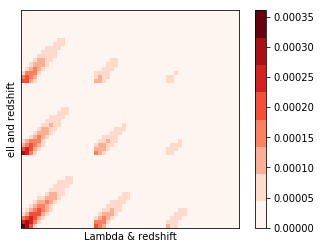

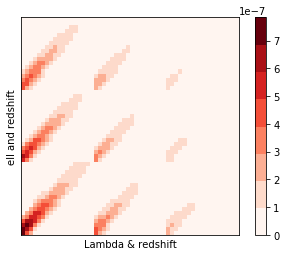

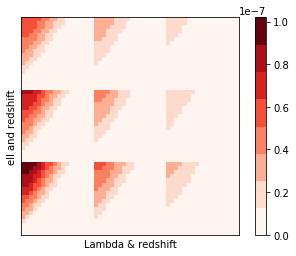

In [33]:
# Consolidating the matrix 
matrix_gg = np.zeros((Num_z_bins*Num_Lbd_bins, Num_z_bins*n_ell))
matrix_gk = np.zeros((Num_z_bins*Num_Lbd_bins, Num_z_bins*n_ell))
matrix_kk = np.zeros((Num_z_bins*Num_Lbd_bins, Num_z_bins*n_ell))

for row in range (Num_z_bins*Num_Lbd_bins):
        for column in range(Num_z_bins*n_ell):
            matrix_gg [row,column] = COV_N_Cl_gg(np.mod(column,Num_z_bins),np.mod(column,Num_z_bins),np.mod(row,Num_z_bins), row//Num_z_bins)[column//Num_z_bins]
            matrix_gk [row,column]= COV_N_Cl_gk(np.mod(column,Num_z_bins),np.mod(column,Num_z_bins),np.mod(row,Num_z_bins), row//Num_z_bins)[column//Num_z_bins]
            matrix_kk [row,column] = COV_N_Cl_kk(np.mod(column,Num_z_bins),np.mod(column,Num_z_bins),np.mod(row,Num_z_bins), row//Num_z_bins)[column//Num_z_bins]
                

            
plt.imshow(np.rot90(matrix_gg), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Lambda & redshift")
plt.ylabel ("ell and redshift")
plt.show()        

plt.imshow(np.rot90(matrix_gk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Lambda & redshift")
plt.ylabel ("ell and redshift")
plt.show()        

plt.imshow(np.rot90(matrix_kk), cmap=plt.cm.get_cmap('Reds', 8))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("Lambda & redshift")
plt.ylabel ("ell and redshift")
plt.show()        
             



In [30]:
np.linalg.eigvals(matrix_gg)

array([ 2.72031627e-03+0.00000000e+00j,  1.44868592e-03+0.00000000e+00j,
        8.17711579e-04+0.00000000e+00j,  4.89475358e-04+0.00000000e+00j,
        2.98174540e-04+0.00000000e+00j,  1.72765389e-04+0.00000000e+00j,
        9.07154732e-05+0.00000000e+00j,  4.27855211e-05+0.00000000e+00j,
        1.81668480e-05+0.00000000e+00j,  6.94794150e-06+0.00000000e+00j,
        2.38768672e-06+0.00000000e+00j,  7.32122603e-07+0.00000000e+00j,
        1.97734136e-07+0.00000000e+00j,  4.60218409e-08+0.00000000e+00j,
        8.91932966e-09+0.00000000e+00j,  1.34255426e-09+0.00000000e+00j,
        1.33568260e-10+0.00000000e+00j,  6.42849105e-12+0.00000000e+00j,
       -6.72272610e-20+0.00000000e+00j,  1.14404242e-20+0.00000000e+00j,
       -1.37225596e-22+9.84558246e-21j, -1.37225596e-22-9.84558246e-21j,
       -9.79698524e-21+0.00000000e+00j,  7.17589618e-21+1.93631114e-21j,
        7.17589618e-21-1.93631114e-21j, -3.82653591e-21+3.21494321e-22j,
       -3.82653591e-21-3.21494321e-22j,  3.21263611

In [ ]:
test_position_position = np.array([ccl.angular_cl(cosmo, Gal_position[i], Gal_position[i],200) for i in range(Num_z_bins)])
test_position_shear = np.array([ccl.angular_cl(cosmo, Gal_position[i], Gal_shear[i],200) for i in range(Num_z_bins)])
test_shear_shear = np.array([ccl.angular_cl(cosmo, Gal_shear[i], Gal_shear[i],200) for i in range(Num_z_bins)])


In [ ]:
plt.plot(Z_bins[:-1], test_position_position)
plt.xlabel("Redshift bins")
plt.ylabel("Cl-gg for l = 200")
plt.show()

In [ ]:
plt.plot(Z_bins[:-1], test_position_shear)
plt.xlabel("Redshift bins")
plt.ylabel("Cl-gk for l = 200")
plt.show()

In [ ]:
plt.plot(Z_bins[:-1], test_shear_shear)
plt.xlabel("Redshift bins")
plt.ylabel("Cl-kk for l = 200")
plt.show()

In [ ]:
help(ccl.pk2d)

In [ ]:
help(ccl.WeakLensingTracer)

In [ ]:
print(np.pi)

In [ ]:
for i in range(30):
    alpha = np.random.uniform(0.2,0.4)
    beta = np.random.uniform(0.02,0.06)
    gamma = np.random.uniform(0.5,0.8)
    delta  = np.random.uniform(-1.3,-0.7)
    print("interaction: " + str(i))
    print(alpha,beta,gamma,delta)
    print(ccl.linear_matter_power(ccl.Cosmology(Omega_c = alpha, Omega_b = beta, Omega_k = 0, A_s = 2.1e-9, n_s = 0.96, h = gamma, w0 = delta), 0.01,1))
    print(ccl.massfunc(ccl.Cosmology(Omega_c = alpha, Omega_b = beta, Omega_k = 0, A_s = 2.1e-9, n_s = 0.96, h = gamma, w0 = delta), 1e13,1))
    print('\n')

In [29]:
print(lpk_array.T.shape)

(1024, 150)
